# Reimplementation of Bootstrap Your Own Latent

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip freeze > requirements.txt

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models
from torchvision.transforms import (
    Compose,
    Resize,
    ToTensor,
    Normalize,
    RandomApply,
    RandomGrayscale,
    RandomCrop,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomRotation,
    GaussianBlur,
    ColorJitter
)

In [ ]:
# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [ ]:
# Set seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

## Dataset Class

In [ ]:
class BYOLDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, _ = self.dataset[index]
        view1 = self.transform(image)
        view2 = self.transform(image)
        return view1, view2

    def __len__(self):
        return len(self.dataset)

## Online and Target Network Classes
Online Network: Updates during training and is responsible for generating representations  
Target Network: Provides stable representations that the online network learns to match

In [ ]:
class OnlineNetwork(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=4096, output_dim=256):
        super(OnlineNetwork, self).__init__()
        self.encoder = get_resnet18_enc()
        self.projector = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.predictor = nn.Sequential(
            nn.Linear(output_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        y = self.encoder(x)
        z = self.projector(y)
        p = self.predictor(z)
        return p, z

In [ ]:
class TargetNetwork(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=4096, output_dim=256):
        super(TargetNetwork, self).__init__()
        self.encoder = get_resnet18_enc()
        self.projector = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        y = self.encoder(x)
        return self.projector(y)

### Exponential Moving Average (EMA)
Formula: $\xi = \tau\xi + (1 - \tau)\theta$

In [ ]:
def update_moving_average(online_net, target_net, momentum):
    # Update encoder
    for param_o, param_t in zip(online_net.encoder.parameters(), target_net.encoder.parameters()):
        param_t.data = param_t.data * momentum + param_o.data * (1.0 - momentum)

    # Update projector
    for param_o, param_t in zip(online_net.projector.parameters(), target_net.projector.parameters()):
        param_t.data = param_t.data * momentum + param_o.data * (1.0 - momentum)

### Loss Function
$\text{Cosine Similarity} = \frac{A \cdot B}{\|A\| \|B\|}$

In [ ]:
def loss_function(p, z):
    p = F.normalize(p, dim=1)
    z = F.normalize(z.detach(), dim=1)

    similarity = (p * z).sum(dim=1)
    loss = 2 - 2 * similarity
    avg_loss = loss.mean()

    return avg_loss

In [ ]:
def get_resnet18_enc():
    # FOR CIFAR-10 DATASET
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.bn1 = nn.BatchNorm2d(64)
    model.relu = nn.ReLU(inplace=True)
    model.maxpool = nn.Identity()
    model.fc = nn.Identity()

    return model

In [ ]:
def get_resnet50_enc():
    model = models.resnet50(weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.bn1 = nn.BatchNorm2d(64)
    model.relu = nn.ReLU(inplace=True)
    model.maxpool = nn.Identity()
    model.fc = nn.Identity()

    return model

### Training Loop

In [ ]:
def train_BYOL(online_net, target_net, num_epochs, train_loader, optimizer, momentum, device):
    train_len = len(train_loader)
    losses = list()

    for epoch in range(num_epochs):
        loss_accumulator = 0
        online_net.train()

        for image, (view1, view2) in enumerate(train_loader):
            view1, view2 = view1.to(device), view2.to(device)

            # Online net forward pass
            (p1, _) = online_net(view1)
            (p2, _) = online_net(view2)

            # Target net forward pass w/o gradients
            with torch.no_grad():
                z1, z2 = target_net(view1), target_net(view2)

            loss = loss_function(p1, z2) + loss_function(p2, z1)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            update_moving_average(online_net, target_net, momentum)

            loss_accumulator += loss.item()

        avg_loss = loss_accumulator / train_len
        losses.append(avg_loss)
        print(f"Epoch: {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

    # Plot loss
    plt.figure()
    plt.plot(range(1, num_epochs + 1), losses)
    plt.xlabel("Epoch")
    plt.ylabel("BYOL Training Loss")
    plt.title("Loss Over Epochs")
    plt.show()

In [ ]:
# Dataset Stats
raw_train_data = datasets.CIFAR10(root='data', train=True, download=True)
data = torch.stack([ToTensor()(img) for img, _ in raw_train_data])
mean = data.mean([0, 2, 3])
std = data.std([0, 2, 3])

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Extracting data/cifar-10-python.tar.gz to data


In [ ]:
# Augmentation
color_jitter = ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2)
SIMCLR_augmentation = Compose([
    RandomResizedCrop((32, 32)),
    RandomHorizontalFlip(),
    RandomGrayscale(p=0.2),
    RandomApply([color_jitter], p=0.3),
    RandomApply([GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.2),
    ToTensor(),
    Normalize(mean=mean.tolist(), std=std.tolist())
])

new_augmentation = Compose([
    RandomResizedCrop(32, scale=(0.8, 1.0)),
    RandomHorizontalFlip(),
    RandomGrayscale(p=0.2),
    ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    ToTensor(),
    Normalize(mean=mean.tolist(), std=std.tolist())
])

transform = new_augmentation

# TODO: Look into other transforms such as vertical flip

In [ ]:
print(f"Statistics:\nMean = {mean}\nStandard Deviation = {std}")

Statistics:
Mean = tensor([0.4914, 0.4822, 0.4465])
Standard Deviation = tensor([0.2470, 0.2435, 0.2616])


In [ ]:
# Load data
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
train_dataset = BYOLDataset(train_data, transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

Files already downloaded and verified


In [ ]:
def initialize_model():
    online_net = OnlineNetwork().to(device)
    target_net = TargetNetwork().to(device)
    optimizer = optim.Adam(online_net.parameters(), lr=0.001)

    # Set target net params with online net params and freeze gradients for target net
    for param_o, param_t in zip(online_net.encoder.parameters(), target_net.encoder.parameters()):
        param_t.data.copy_(param_o.data)
        param_t.requires_grad = False

    for param_o, param_t in zip(online_net.projector.parameters(), target_net.projector.parameters()):
        param_t.data.copy_(param_o.data)
        param_t.requires_grad = False

    return online_net, target_net, optimizer

In [ ]:
def save_model(num_epochs, momentum, model_path="byol_model.pth"):
    online_net, target_net, optimizer = initialize_model()
    train_BYOL(
        online_net=online_net,
        target_net=target_net,
        num_epochs=num_epochs,
        train_loader=train_loader,
        optimizer=optimizer,
        momentum=momentum,
        device=device
    )
    torch.save(online_net.state_dict(), model_path)
    print(f"Model Path: {model_path}")

Epoch: 1/30, Average Loss: 0.8165
Epoch: 2/30, Average Loss: 0.4630
Epoch: 3/30, Average Loss: 0.2831
Epoch: 4/30, Average Loss: 0.2044
Epoch: 5/30, Average Loss: 0.1745
Epoch: 6/30, Average Loss: 0.1604
Epoch: 7/30, Average Loss: 0.1524
Epoch: 8/30, Average Loss: 0.1438
Epoch: 9/30, Average Loss: 0.1369
Epoch: 10/30, Average Loss: 0.1322
Epoch: 11/30, Average Loss: 0.1264
Epoch: 12/30, Average Loss: 0.1218
Epoch: 13/30, Average Loss: 0.1154
Epoch: 14/30, Average Loss: 0.1148
Epoch: 15/30, Average Loss: 0.1141
Epoch: 16/30, Average Loss: 0.1110
Epoch: 17/30, Average Loss: 0.1077
Epoch: 18/30, Average Loss: 0.1031
Epoch: 19/30, Average Loss: 0.0994
Epoch: 20/30, Average Loss: 0.0966
Epoch: 21/30, Average Loss: 0.0947
Epoch: 22/30, Average Loss: 0.0926
Epoch: 23/30, Average Loss: 0.0917
Epoch: 24/30, Average Loss: 0.0902
Epoch: 25/30, Average Loss: 0.0904
Epoch: 26/30, Average Loss: 0.0888
Epoch: 27/30, Average Loss: 0.0863
Epoch: 28/30, Average Loss: 0.0855
Epoch: 29/30, Average Loss: 0

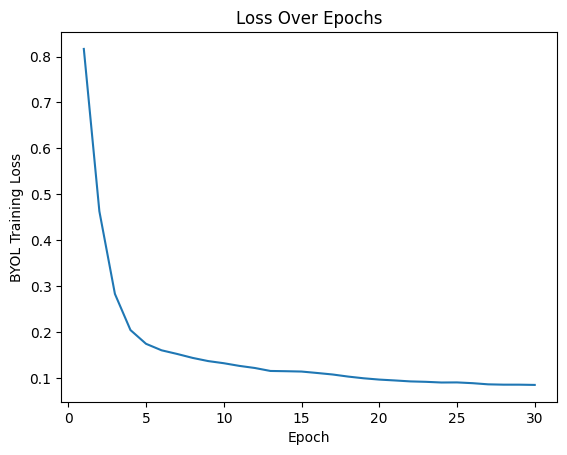

Model Path: /content/drive/MyDrive/BYOL/byol_model.pth


In [ ]:
save_model(num_epochs=30, momentum=0.995, model_path="/content/drive/MyDrive/BYOL/byol_model.pth")

In [ ]:
def load_trained_encoder(model_path):
    online_net = OnlineNetwork().to(device)
    online_net.load_state_dict(torch.load(model_path))
    return online_net.encoder

In [ ]:
# Load trained encoder
encoder = load_trained_encoder(model_path="/content/drive/MyDrive/BYOL/byol_model.pth")
encoder.eval()

<ipython-input-22-a2904319f99e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  online_net.load_state_dict(torch.load(model_path))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, encoder, num_classes, output_size):
        super(LinearClassifier, self).__init__()
        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        self.classifier = nn.Linear(output_size, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)

        return self.classifier(features)

In [ ]:
def train_classifier(classifier, train_loader, criterion, optimizer, num_epochs, device):
    classifier.train()
    training_losses = []
    training_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        total = 0
        correct = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = classifier(images)
            loss = criterion(outputs, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = 100.0 * correct / total
        training_losses.append(avg_loss)
        training_accuracies.append(accuracy)
        print(f"Epoch: {epoch + 1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.2f}%")

    # Plot training loss
    plt.figure()
    plt.plot(range(1, num_epochs + 1), training_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Classifier Training Loss")
    plt.legend()
    plt.show()

    # Plot training accuracy
    plt.figure()
    plt.plot(range(1, num_epochs + 1), training_accuracies, label="Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Classifier Training Accuracy")
    plt.legend()
    plt.show()

In [ ]:
def evaluate_classifier(classifier, test_loader, device):
    classifier.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = classifier(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    return accuracy

In [ ]:
# Initialize classifier, loss function, and optimizer
classifier = LinearClassifier(encoder, num_classes=10, output_size=512).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.classifier.parameters(), lr=0.001)

In [ ]:
test_transform = Compose([
    ToTensor(),
    Normalize(mean=mean.tolist(), std=std.tolist())
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

Files already downloaded and verified


In [ ]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=test_transform)
train_loader_classifier = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)

Files already downloaded and verified


Epoch: 1/25, Avg Loss: 1.4229, Training Accuracy: 49.72%
Epoch: 2/25, Avg Loss: 1.2629, Training Accuracy: 55.08%
Epoch: 3/25, Avg Loss: 1.2152, Training Accuracy: 56.94%
Epoch: 4/25, Avg Loss: 1.1848, Training Accuracy: 58.05%
Epoch: 5/25, Avg Loss: 1.1628, Training Accuracy: 59.00%
Epoch: 6/25, Avg Loss: 1.1455, Training Accuracy: 59.61%
Epoch: 7/25, Avg Loss: 1.1314, Training Accuracy: 60.13%
Epoch: 8/25, Avg Loss: 1.1194, Training Accuracy: 60.55%
Epoch: 9/25, Avg Loss: 1.1091, Training Accuracy: 60.92%
Epoch: 10/25, Avg Loss: 1.1000, Training Accuracy: 61.26%
Epoch: 11/25, Avg Loss: 1.0919, Training Accuracy: 61.57%
Epoch: 12/25, Avg Loss: 1.0847, Training Accuracy: 61.84%
Epoch: 13/25, Avg Loss: 1.0781, Training Accuracy: 62.07%
Epoch: 14/25, Avg Loss: 1.0721, Training Accuracy: 62.26%
Epoch: 15/25, Avg Loss: 1.0665, Training Accuracy: 62.50%
Epoch: 16/25, Avg Loss: 1.0614, Training Accuracy: 62.68%
Epoch: 17/25, Avg Loss: 1.0567, Training Accuracy: 62.83%
Epoch: 18/25, Avg Loss:

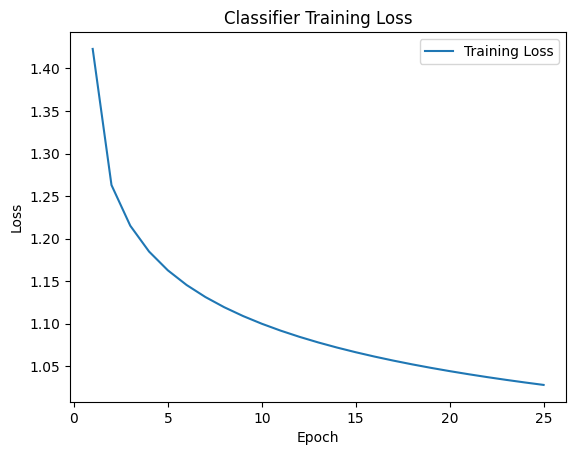

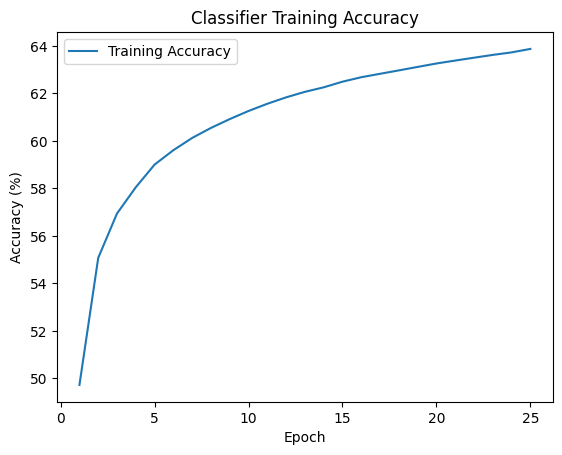

In [ ]:
train_classifier(
    classifier=classifier,
    train_loader=train_loader_classifier,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=25,
    device=device
)

In [ ]:
classifier_accuracy = evaluate_classifier(
    classifier=classifier,
    test_loader=test_loader,
    device=device
)

In [ ]:
print(f"Test Accuracy: {classifier_accuracy:.2f}%")

Test Accuracy: 63.07%
